# Gallery of on-board centroid residuals > 5 arcsec

This notebook creates a nearly complete gallery of instances between 2015:001 to 2017:020 when on-board centroid residuals for a star slot exceeded 5 arcsec.  

Approximately 100 cases are identified where an obsid/slot has at least one interval of significant centroid residuals above 5 arcsec.

These have all been examined and fall into a few broad categories:
- Star centroid perturbed significantly by a hot pixel.
- Tracking a warm/hot pixel (no star any more).
- Cosmic ray injects a high tracking velocity and ACA is not tracking any persistent structure.
- Bona fide spoiler star being tracked.

No cases were seen where centroids being reported would provide beneficial input to the Kalman filter.  This might be possible if the intended star were being faithfully tracked but with large (zero-mean) noise, but this is not observed.  **The proposed OBC Kalman limit patch is reasonable, meaning it always has the intended effect of eliminating bad data that would increase the error in attitude estimate.**

One case is shown which demonstrates that errors in the on-board attitude estimate closely track the errors in one outlier slot.  The tracking is roughly linear, implying a reduction of the Kalman limit from 20 to 5 arcsec will reduce attitude errors by approximately a factor of 4 in outlier cases such as these.  When outlier data are excluded from the Kalman filter, the attitude estimate errors converge to nearly zero within about 30 seconds.  **The Kalman limit patch is effective, meaning that it will substantially reduce the risk of a safing action due to tracking a hot pixel.**

## Processing is done in the following manner:

### For each obisid in the range 2015:001 to 2017:020

#### Data acquisition and prep
- Determine which slots are tracking stars
- Fetch telemetry from the Ska archive for each star during the Kalman period of the obsid:
  - ACA function (TRAK or not) (`aoacfct`)
  - Saturated pixel and Ionizing radiation status (`aoacisp`, `aoaciir`)
  - Y and Z angle centroids (`aoacyan`, `aoaczan`)
  - Attitude quaternions (`aoattqt`)
- Interpolate data onto a common time grid with 2.05 second steps.
- For all MSIDs, filter out bad times when one or more quaternion values are not available.
- For MSIDs associated with each slot, filter out bad times when one or more value is not available.

#### Centroid residuals (for each slot)
- Determine star AGASC ID by using a representive yag/zag from the observation midpoint, and computing star RA, Dec
  using estimated S/C attitude.
- Compute centroid residuals using estimated S/C attitude and star RA, Dec.
- Create a value `dyz` which is the max of the absolute value of yag, zag at each time sample

#### Find intervals of significant residuals > 5 arcsec
- In order to filter transients from cosmic rays and other isolated events, make an
  array which indicates points where `gt5 = dyz > 5 arcsec` (1 if True, 0 if False).
- Apply a simple boxcar average to `gt5` with a boxcare length of 64 samples (approx. 2 minutes).  This is called `sm_gt5`.
- Points where the boxcar average `sm_gt5` is above 0.25 are flagged.
- This represents times when at least 16 of 64 samples have large centroid residuals.
- This filter strategy removes transients and reflects conditions when large residuals are significantly impacting spacraft attitude.

#### Make dashboard plot
- DYZ plot for whole observation:
  - `dyz` (blue) vs. time since Kalman start
  - 5 arcsec threshold plotted as blue dashed line
  - Times with `sm_gt5 > 0.25` are plotted in maroon
  - `sm_gt5 * 10` plotted in red
  - 0.25 threshold plotted in red dashed line
- DYZ plot for +/- 300 seconds and image plot for three cases:
  - Sample at 98th percentile (in `dyz`) of points with `dyz > 5`.  Close to worst-case residual but tolerant to single outliers.
  - Sample which is the closest to `dyz = 5`.  This is a representative sample just near the threshold.
  - Sample at the peak of `sm_gt5`.  This represents the maximum density of bad points.
  
### Data files

The data files created by and required by this notebook are in `/proj/sot/ska/analysis/gyro_bias/kalman_threshold`.  This notebook is part of the `gyro_bias` repo in the `sot` GitHub area.

In [1]:
# For interactive work and to reproduce the inline plots use the following.
# This requires files in the `data` and `processed` directories that are in
# /proj/sot/ska/analysis/gyro_bias/kalman_threshold.
# %matplotlib notebook

# For run-for-record just do inline
%matplotlib inline

# For production processing (in particular for making plots) use the following
# import matplotlib
# matplotlib.use('Agg')

import pickle
import os
import sys
import traceback
from glob import glob
import re

import numpy as np

# Need acaimage branch of mica for now
sys.path.insert(0, '/home/aldcroft/git/mica')

import agasc
from mica.archive import aca_l0
from mica import quaternion
from kadi import events
import Ska.engarchive.fetch as fetch
from Chandra.Time import DateTime
import Ska.Numpy
import pyyaks.logger
import matplotlib.pyplot as plt
from Ska.Matplotlib import plot_cxctime
from Ska.engarchive.utils import logical_intervals
from matplotlib.gridspec import GridSpec

In [2]:
logger = pyyaks.logger.get_logger(format='%(asctime)s: %(message)s', level=40)

In [3]:
# MSIDs that apply to a slot and get slot number appended
SLOT_MSIDS = ['aoacfct',
              'aoacisp',
              'aoaciir',
              'aoacyan',
              'aoaczan']

In [4]:
# Attitude quaternion MSIDs
ATT_MSIDS = ['aoattqt1',
             'aoattqt2',
             'aoattqt3',
             'aoattqt4',
             ]

In [5]:
def filter_bad(msid, bads):
    """
    Filter out any bad values from ``msid`` object.

    :param bads: Bad values mask
    """
    if np.any(bads):
        ok = ~bads
        for colname in msid.colnames:
            setattr(msid, colname, getattr(msid, colname)[ok])

In [6]:
def get_archive_data(start, stop):
    """
    Get archive data required for analyzing status flag / centroid
    dependencies.  The start and stop time must correspond to a single
    star catalog and be contained within a Kalman dwell.

    :param start: start time (any Chandra DateTime format)
    :param stop: stop time
    :returns: MSIDset object
    """
    start = DateTime(start)
    stop = DateTime(stop)
    slots = list(range(8))

    # First figure out if any slots (out of 0, 1, 2) are fids and remove
    # from the slots lits if so.
    msids = ['aoimage{}'.format(ii) for ii in range(3)]
    telems = fetch.Msidset(msids, start, start.secs + 100)
    for ii, msid in enumerate(msids):
        if np.any(telems[msid].vals == 'FID '):
            slots.remove(ii)
    logger.info('Using slots {}'.format(slots))

    slot_msids = [msid + "%s" % slot for msid in SLOT_MSIDS for slot in slots]
    msids = slot_msids + ATT_MSIDS

    # Get telemetry
    logger.info('Fetching telemetry from {} to {}'.format(start.date[:17], stop.date[:17]))
    telems = fetch.MSIDset(msids, start, stop)
    start_interp = max(telems[msid].times[0] for msid in msids)
    stop_interp = min(telems[msid].times[-1] for msid in msids)
    logger.info('Interpolating at 2.05 sec intervals over {} to {}'
                .format(DateTime(start_interp).date[:17], DateTime(stop_interp).date[:17]))

    # Interpolate everything onto a common uniform time grid
    telems.interpolate(dt=2.05, start=start_interp, stop=stop_interp, filter_bad=False)

    # Create a bad filter for any samples with no attitude
    att_bads = np.zeros(len(telems[ATT_MSIDS[0]]), dtype=bool)
    for msid in ATT_MSIDS:
        att_bads |= telems[msid].bads
    for msid in ATT_MSIDS:
        telems[msid].bads = att_bads
    logger.info('Attitude: found {} / {} bad values'
                .format(np.sum(att_bads), len(att_bads)))

    # Apply the att_bad filtering for each MSID invidivually (note that the
    # MSIDset.filter_bad() method isn't appropriate here)
    for msid in msids:
        filter_bad(telems[msid], att_bads)

    # Set global times to the times of first in MSIDset because they are all
    # the same at this point
    telems.times = telems[msids[0]].times

    # Create a bad filter for each slot based on the union of all relevant MSIDs
    bad_slots = []
    for slot in slots:
        slot_msids = [msid + "%s" % slot for msid in SLOT_MSIDS]
        slot_bads = np.zeros(len(telems.times), dtype=bool)
        for msid in slot_msids:
            slot_bads |= telems[msid].bads

        # Only accept samples where the ACA reports tracking
        slot_bads |= telems['aoacfct{}'.format(slot)].vals != 'TRAK'
        if len(telems.times) - np.count_nonzero(slot_bads) < 10:
            bad_slots.append(slot)
            continue

        for msid in slot_msids:
            telems[msid].bads = slot_bads
        logger.info('Slot {}: found {} / {} bad or not tracking values'
                    .format(slot, np.sum(slot_bads), len(slot_bads)))
        
    for slot in bad_slots:
        slots.remove(slot)

    return telems, slots

In [7]:
def telems_to_struct(telems, slots):
    """
    Convert input MSIDset to an optimized data structure
    """
    out = {}
    time0 = telems.times[0]
    out['time0'] = time0
    out['bads'] = {}
    out['vals'] = {}
    out['slots'] = slots
    out['agasc_id'] = {}
    out['vals']['dyag'] = {}
    out['vals']['dzag'] = {}
    out['times'] = telems.times
    out['time0s'] = np.array(telems.times - time0, dtype=np.float32)

    for msid in ATT_MSIDS:
        out['vals'][msid] = telems[msid].vals

    # Set bads array for each slot based the first of the SLOT_MSIDS (they
    # all have the same bads array)
    for slot in slots:
        msid = SLOT_MSIDS[0] + str(slot)
        out['bads'][slot] = telems[msid].bads

    for slot_msid in SLOT_MSIDS:
        out['vals'][slot_msid] = {}
        for slot in slots:
            msid = slot_msid + str(slot)
            tlmsid = telems[msid]
            out['vals'][slot_msid][slot] = (tlmsid.vals if tlmsid.raw_vals is None
                                            else tlmsid.raw_vals)

    for slot in slots:
        # Ignore samples that are previously known to be bad (no track or missing MSID)
        # as well as IR or SP flags
        bads = (out['vals']['aoaciir'][slot] | out['vals']['aoacisp'][slot] | out['bads'][slot]).astype(bool)

        # The money routine to calculate centroid residualts
        dyag, dzag, agasc_id = calc_delta_centroids(telems, slot, bads)

        out['vals']['dyag'][slot] = np.array(dyag, dtype=np.float32)
        out['vals']['dzag'][slot] = np.array(dzag, dtype=np.float32)
        out['agasc_id'][slot] = agasc_id
        out['bads'][slot] = bads

    return out

In [8]:
def get_q_atts_transforms(telems, slot, dt):
    """
    Get quaternions and associated transforms, matched to the times of yag/zag data
    in slot.  Apply a time offset ``dt`` to account for latencies in telemetry
    and ACA image readout.
    """
    logger.verbose('Interpolating quaternions for slot {}'.format(slot))
    yz_times = telems['aoacyan{}'.format(slot)].times
    q_times = telems['aoattqt1'].times
    qs = np.empty((len(yz_times), 4), dtype=np.float64)

    for ii in range(4):
        q_vals = telems['aoattqt{}'.format(ii + 1)].vals
        qs[:, ii] = Ska.Numpy.interpolate(q_vals, q_times + dt, yz_times, sorted=True)
    q_atts = quaternion.Quat(quaternion.normalize(qs))
    transforms = q_atts.transform  # N x 3 x 3
    return q_atts, transforms

In [9]:
# Various utilities

def eci2radec(eci):
    ra = np.degrees(np.arctan2(eci[1], eci[0]))
    dec = np.degrees(np.arctan2(eci[2], np.sqrt(eci[1] ** 2 + eci[0] ** 2)))
    ra = np.mod(ra, 360)
    return ra, dec

def yagzag2radec(yag, zag, q):
    d_aca = np.array([1.0, np.tan(np.radians(yag)), np.tan(np.radians(zag))])
    d_aca *= 1.0 / np.sum(d_aca ** 2)
    eci = np.dot(q.transform, d_aca)
    return eci2radec(eci)

def radec2eci(ra, dec):
    r = np.radians(ra)
    d = np.radians(dec)
    return np.array([np.cos(r) * np.cos(d), np.sin(r) * np.cos(d), np.sin(d)])

def radec2yagzag(ra, dec, transforms_transpose):
    eci = radec2eci(ra, dec)
    d_aca = np.dot(transforms_transpose, eci)
    yag = np.degrees(np.arctan2(d_aca[:, 1], d_aca[:, 0]))
    zag = np.degrees(np.arctan2(d_aca[:, 2], d_aca[:, 0]))
    return yag, zag

In [10]:
def calc_delta_centroids(telems, slot, bads, dt=3.0, use_agasc=True):
    """
    Calculate centroid residuals for ``slot`` using ``telems`` data.
    If ``use_agasc`` is True then try to find the AGASC star based on
    a centroid at the center.
    """
    yags = telems['aoacyan{}'.format(slot)].vals / 3600.
    zags = telems['aoaczan{}'.format(slot)].vals / 3600.
    q_atts, transforms = get_q_atts_transforms(telems, slot, dt=dt)

    ok = ~bads
    qs = q_atts.q[ok]
    n_mid = len(qs) // 2
    q_att0 = quaternion.Quat(qs[n_mid])
    ra0, dec0 = yagzag2radec(yags[ok][n_mid], zags[ok][n_mid], q_att0)

    if use_agasc:
        # Find the star that this must be
        stars = agasc.get_agasc_cone(ra0, dec0, radius=30 / 3600.)
        stars.sort('MAG_ACA')
        if len(stars) == 0:
            raise ValueError('no star within 30" of {} {} for slot {}'.format(ra0, dec0, slot))
        star = stars[0]
        if star['MAG_ACA'] > 10.8:
            raise ValueError('no star brighter than 10.8 within 30" of {} {} for slot {}'
                            .format(ra0, dec0, slot))
        ra0 = star['RA_PMCORR']
        dec0 = star['DEC_PMCORR']

    agasc_id = star['AGASC_ID'] if use_agasc else None

    transforms_transpose = transforms.transpose(0, 2, 1)

    p_yags, p_zags = radec2yagzag(ra0, dec0, transforms_transpose)
    d_yags = p_yags - yags
    d_zags = p_zags - zags
    if not use_agasc:
        d_yags = d_yags - np.median(d_yags[ok])
        d_zags = d_zags - np.median(d_zags[ok])


    # For this application, set bad centroids to 0.0
    d_yags[bads] = 0.0
    d_zags[bads] = 0.0
    
    return d_yags * 3600, d_zags * 3600, agasc_id

In [11]:
class ObsidValueError(Exception):
    pass

def get_obsid(obsid, dt=3.0):
    """
    Get centroid data structure for ``obsid``
    """
    obsids = events.obsids.filter(obsid__exact=obsid)
    if len(obsids) == 0:
        raise ObsidValueError('No obsid={} in kadi database'.format(obsid))

    dwells = events.dwells.filter(obsids[0].start, obsids[0].stop)
    obsid_dwells = [dwell for dwell in dwells if dwell.start > obsids[0].start]
    logger.info('Using obsid dwell(s): {}'
                .format(','.join(str(dwell) for dwell in obsid_dwells)))

    if not obsid_dwells:
        raise ObsidValueError('No dwells in obsid {}'.format(obsid))

    tstart = DateTime(obsid_dwells[0].start).secs
    tstop = DateTime(obsid_dwells[-1].stop).secs

    # Get raw telemetry data from archive
    telems, slots = get_archive_data(tstart, tstop)

    # Process telemetry data, do filtering, and compute centroids
    out = telems_to_struct(telems, slots)
    out['obsid'] = obsid

    return out

In [12]:
# https://github.com/alexanderkuk/log-progress

def log_progress(sequence, every=None, size=None):
    """
    Make a nice progress bar widget.
    """
    from ipywidgets import IntProgress, HTML, VBox
    from IPython.display import display

    is_iterator = False
    if size is None:
        try:
            size = len(sequence)
        except TypeError:
            is_iterator = True
    if size is not None:
        if every is None:
            if size <= 200:
                every = 1
            else:
                every = int(size / 200)     # every 0.5%
    else:
        assert every is not None, 'sequence is iterator, set every'

    if is_iterator:
        progress = IntProgress(min=0, max=1, value=1)
        progress.bar_style = 'info'
    else:
        progress = IntProgress(min=0, max=size, value=0)
    label = HTML()
    box = VBox(children=[label, progress])
    display(box)

    index = 0
    try:
        for index, record in enumerate(sequence, 1):
            if index == 1 or index % every == 0:
                if is_iterator:
                    label.value = '{index} / ?'.format(index=index)
                else:
                    progress.value = index
                    label.value = u'{index} / {size}'.format(
                        index=index,
                        size=size
                    )
            yield record
    except:
        progress.bar_style = 'danger'
        raise
    else:
        progress.bar_style = 'success'
        progress.value = index
        label.value = str(index or '?')

In [13]:
def get_intervals(dat, slot, thresh=5.0, duty_cycle=0.25, n_smooth=64):
    """
    Get intervals where centroid residuals in ``slot`` are above 
    ``thresh`` arcsec for at least ``duty_cycle`` fraction of
    the time.  This computes duty cycle as a running box-car smooth
    of length ``n_smooth`` samples.
    """
    from astropy.convolution import convolve, Box1DKernel
    dyz = np.maximum(np.abs(dat['vals']['dyag'][slot]), 
                     np.abs(dat['vals']['dzag'][slot]))
    gt5 = np.where(dyz > thresh, 1.0, 0.0)
    sm_gt5 = convolve(gt5, Box1DKernel(n_smooth))
    intervals = logical_intervals(dat['times'], sm_gt5 > duty_cycle)
    return intervals, dyz, gt5, sm_gt5

In [14]:
def process_obsids(start='2016:020', stop='2016:030'):
    """
    Process obsids in a time range.  The key elements is a call to
    `get_obsid()` to actually get the telemetry data as a nicely
    structured dict.  This also does all the heavy lifting of
    data filtering and centroiding.
    
    The rest of this has to do with handling processing, making
    sure an obsid has been processed fully, writing data files, etc.
    """
    obsid_evts = list(events.obsids.filter(start, stop))
    for obsid_evt in log_progress(obsid_evts, every=1):
        obsid = obsid_evt.obsid

        # If file exists in `processed` directory then it was already done
        processed_fn = os.path.join('processed', '{}'.format(obsid))
        if os.path.exists(processed_fn) or os.path.exists(processed_fn + '.err'):
            continue

        try:
            # Main work here of getting centroid data for this obsid
            dat = get_obsid(obsid)
        except Exception as err:
            with open(processed_fn + '.err', 'w') as fh:
                traceback.print_tb(err.__traceback__, file=fh)
                fh.write('\n' + str(err) + '\n')
            continue

        for slot in dat['slots']:
            intervals, *rest = get_intervals(dat, slot)
            if len(intervals) > 0:
                pklname = os.path.join('data', '{}.pkl'.format(obsid))
                if not os.path.exists(pklname):
                    pickle.dump(dat, open(pklname, 'wb'), protocol=-1)
                intvlname = os.path.join('data', '{}_{}.dat'.format(obsid, slot))
                for name in ('duration', 'tstart', 'tstop'):
                    intervals[name].format = '.2f'
                intervals.write(intvlname, format='ascii.basic')

        with open(processed_fn, 'w') as fh:
            pass


In [15]:
def get_dat(obsid):
    """
    Get centroids data structure for an obsid, either from pre-existing pickle
    or from scratch using telemetry
    """
    try:
        dat = pickle.load(open(os.path.join('data', '{}.pkl'.format(obsid)), 'rb'))
    except IOError:
        dat = get_obsid(obsid)
    dat['obsid'] = obsid
    
    return dat

In [16]:
def plot_img(dat, slot, dt, ax=None):
    """
    Draw ACA image.
    """
    time = dat['time0'] + dt
    tstart = time - 10
    tstop = time + 10
    imgs = aca_l0.get_l0_images(start=tstart, stop=tstop, slot=slot)
    img_times = [img.TIME for img in imgs]
    i0 = np.searchsorted(img_times, time)
    img = imgs[i0]
    vmin = -50
    vmax = max(np.max(img) * 1.05, 300.0)

    if ax is None:
        plt.figure()
        ax = plt.subplot(1, 1, 1)
    else:
        plt.sca(ax)


    plt.imshow(img, vmin=vmin, vmax=vmax, interpolation='nearest', cmap='hot')
    plt.colorbar()

In [17]:
def plot_sub_dyz(times, time0, dyz, sm_gt5, intervals, ax=None, i_off=None):
    """
    Make DYZ plot.
    """
    abs_times = times + time0

    if i_off is not None:
        dt = times[i_off]
        i0, i1 = np.searchsorted(times, [dt - 300, dt + 300])
        
        dyz = dyz[i0:i1]
        sm_gt5 = sm_gt5[i0:i1]
        times = times[i0:i1] - dt
        abs_times = abs_times[i0:i1]
    else:
        dt = None
        
    ax.plot(times, dyz, 'b')
    ax.plot(times, sm_gt5 * 10, 'r')
    ax.plot([times[0], times[-1]], [5, 5], 'b--')
    ax.plot([times[0], times[-1]], [2.5, 2.5], 'r--')
    ax.set_ylabel('Resid (arcsec)')
    for tstart, tstop in intervals['tstart', 'tstop']:
        i0, i1 = np.searchsorted(abs_times, [tstart, tstop])
        if i0 != i1:
            ax.plot(times[i0:i1], dyz[i0:i1], 'm')

    return dt

In [18]:
def plot_dashboard(dat, slot):
    """
    Plot dyz (max of dyag, dzag) vs. relative time for centroids data structure
    ``dat`` for ``slot``.
    """
    plt.figure(figsize=(6, 7.5))
    gs = GridSpec(4, 2, width_ratios=[2, 1.4])
    ax1 = plt.subplot(gs[0, :])
    ax2 = plt.subplot(gs[1, :1])
    ax3 = plt.subplot(gs[1, 1:])
    ax4 = plt.subplot(gs[2, :1])
    ax5 = plt.subplot(gs[2, 1:])
    ax6 = plt.subplot(gs[3, :1])
    ax7 = plt.subplot(gs[3, 1:])

    intervals, dyz, gt5, sm_gt5 = get_intervals(dat, slot)
    bads = (dat['vals']['aoaciir'][slot] | dat['vals']['aoacisp'][slot] 
            | dat['bads'][slot]).astype(bool)
    times = dat['time0s']
    dyz[bads] = -0.5

    plot_sub_dyz(times, dat['time0'], dyz, sm_gt5, intervals, ax1)
    ax1.set_title('Obsid {} slot {} at {}'.format(dat['obsid'], slot,
                                          DateTime(dat['time0']).date[:17]))
        
    # Plot dyz and image for +/- 300 seconds around 98% percentile dyz
    mask =  dyz > 5
    if np.count_nonzero(mask) > 10:
        dyz98 = np.percentile(dyz[mask], 98.0)
        i_off = np.argmin(np.abs(dyz - dyz98))
        dt =plot_sub_dyz(times, dat['time0'], dyz, sm_gt5, intervals, ax=ax2, i_off=i_off)
        ax2.set_title('98th percentile')
        plot_img(dat, slot, dt, ax3)

    # Plot dyz and image for +/- 300 seconds around representative 5 arcsec offset
    i_off = np.argmin(np.abs(dyz - 5.0))
    dt = plot_sub_dyz(times, dat['time0'], dyz, sm_gt5, intervals, ax=ax4, i_off=i_off)
    ax4.set_title('Representative 5 arcsec')
    plot_img(dat, slot, dt, ax5)

    # Plot dyz and image for +/- 300 seconds around peak of sm_gt5
    i_off = np.argmax(sm_gt5)    
    dt = plot_sub_dyz(times, dat['time0'], dyz, sm_gt5, intervals, ax=ax6, i_off=i_off)
    ax6.set_title('Peak > 5 arcsec duty cycle')
    plot_img(dat, slot, dt, ax7)

    plt.tight_layout()

In [19]:
def plot_obsids():
    """
    Plot processed obsids.
    """
    for dat_fn in glob('data/*.dat'):
        m = re.search(r'(\d+)_(\d)', dat_fn)
        obsid = int(m.group(1))
        slot = int(m.group(2))
        plot_fn = 'data/{}_{}.png'.format(obsid, slot)
        if os.path.exists(plot_fn):
            continue
        dat = get_dat(obsid)
        
        # Bogus cases (associated with safing events) where residuals are
        # unphysically large.
        if np.percentile(sm_gt5, 95) > 1000:
            continue

        plot_dashboard(dat, slot)
        plt.savefig(plot_fn)
        plt.close('all')
        print(plot_fn)

In [20]:
def plot_images(dat, slot, dt0, dt1):
    """
    Helper routine to plot up to 8 images within a time interval.
    """
    tstart = dat['time0'] + dt0
    tstop = dat['time0'] + dt1
    imgs = aca_l0.get_l0_images(start=tstart, stop=tstop, slot=slot)

    for ii, img in enumerate(imgs[:8]):
        vmin = -50
        vmax = max(np.max(img) * 1.05, 300.0)
        plt.figure(10 + ii)
        ax = plt.subplot(1, 1, 1)
        plt.imshow(img, vmin=vmin, vmax=vmax, interpolation='nearest', cmap='hot')
        plt.title('dt={} row0={} col0={}'.format(img.TIME - dat['time0'], img.row0, img.col0))
        plt.colorbar()

## Production runs to do processing

In [21]:
# Production run to find > 5 arcsec centroid deviations since 2015
process_obsids(start='2015:001', stop='2017:020')

In [22]:
# Production run to create all dashboard plots
plot_obsids()

## Representative obsids

- **50422 slot 7**: perfect spoiler star being tracked
- **50725 slot 3**: Cosmic ray during perigee starts fast track (20-30 arcsec / readout)
- **50767 slot 5**: Residuals ramp up to > 20 arcsec.  Look at other slots for attitude estimate impact.
- **51622 slot 6**: short (< 5 sec) transient of 100 arcsec. No obvious hot pixel.
- **18446 slot 5**: Hot pixel, just before 2016:234 BSH

### 50422: Spoiler star being tracked

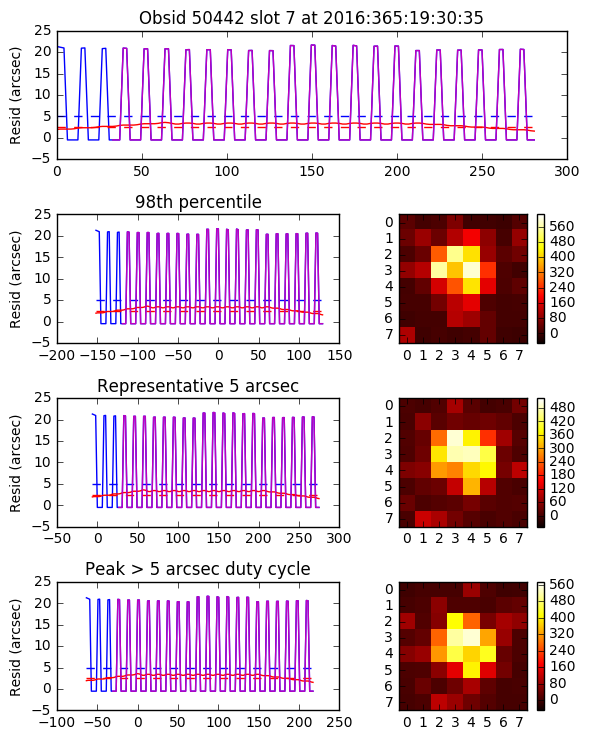

In [23]:
dat = get_dat(50442)
plot_dashboard(dat, slot=7)

### 50725: Cosmic ray during perigee starts fast track (20-30 arcsec / readout)

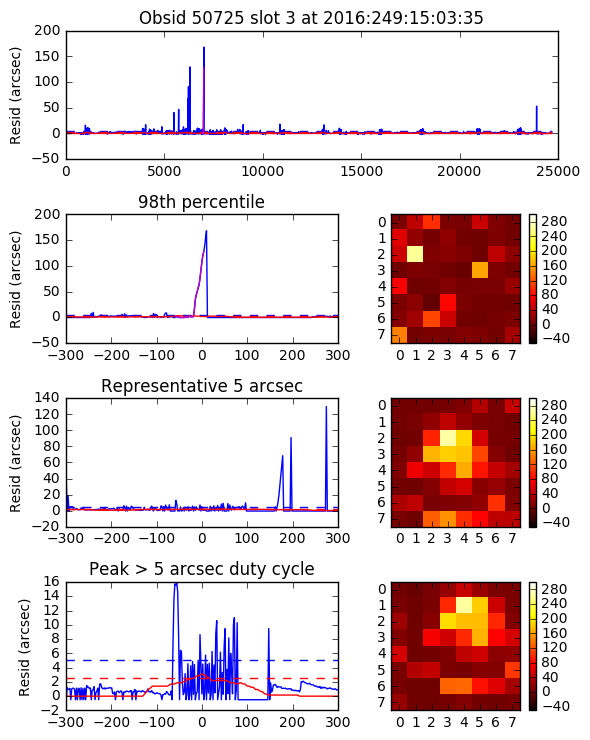

In [24]:
dat = get_dat(50725)
plot_dashboard(dat, slot=3)

### 50767: residuals above and below 20 arcsec

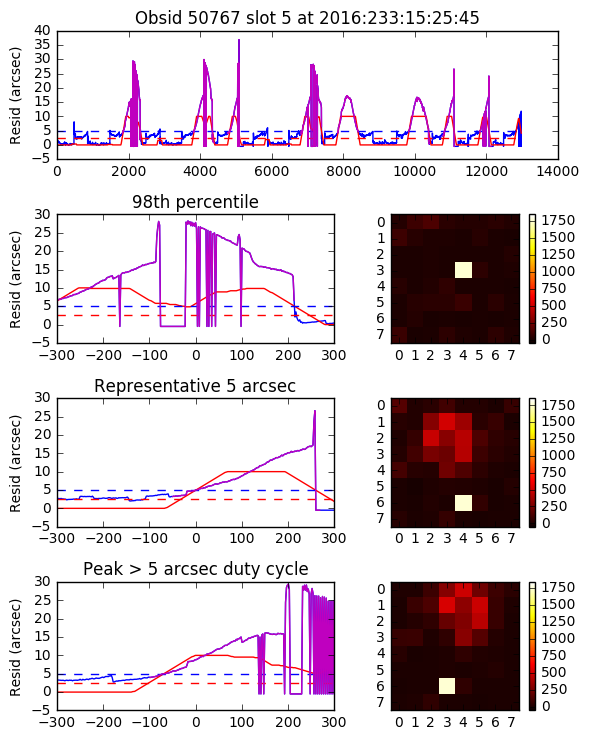

In [25]:
dat = get_dat(50767)
plot_dashboard(dat, slot=5)

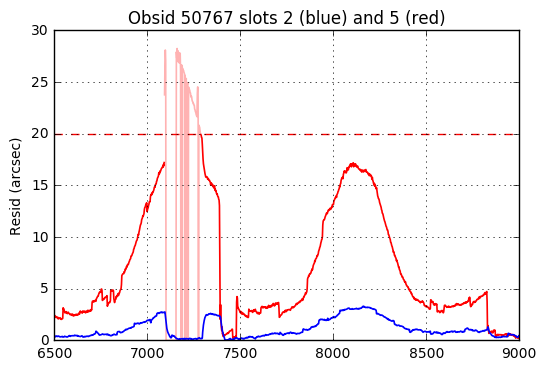

In [26]:
plt.figure(figsize=(6, 4))
t0, t1 = [6500, 9000]
for slot, color in ((5, 'r'), (2, 'b')):
    intervals, dyz, gt5, sm_gt5 = get_intervals(dat, slot)
    bads = (dat['vals']['aoaciir'][slot] | dat['vals']['aoacisp'][slot] 
            | dat['bads'][slot] | (dyz > 20)).astype(bool)
    times = dat['time0s']
    dyz_bads = dyz[bads]
    dyz[bads] = np.nan
    i0, i1 = np.searchsorted(times, [t0, t1])
    plt.plot(times[i0:i1], dyz[i0:i1], color, lw=1.2)
    
    dyz[bads] = dyz_bads
    dyz[~bads] = np.nan
    plt.plot(times[i0:i1], dyz[i0:i1], color, lw=1.2, alpha=0.3)

plt.plot([t0, t1], [20, 20], 'r--')
plt.ylabel('Resid (arcsec)')
plt.title('Obsid 50767 slots 2 (blue) and 5 (red)')
plt.grid()

#### Two slots in 50767

This shows that the OBC patch will be **effective** at reducing
the error in OBC estimated attitude which occurs when
the ACA produces erroneous centroid values.

### 51622: short (< 5 sec) transient of 100 arcsec. No obvious hot pixel.

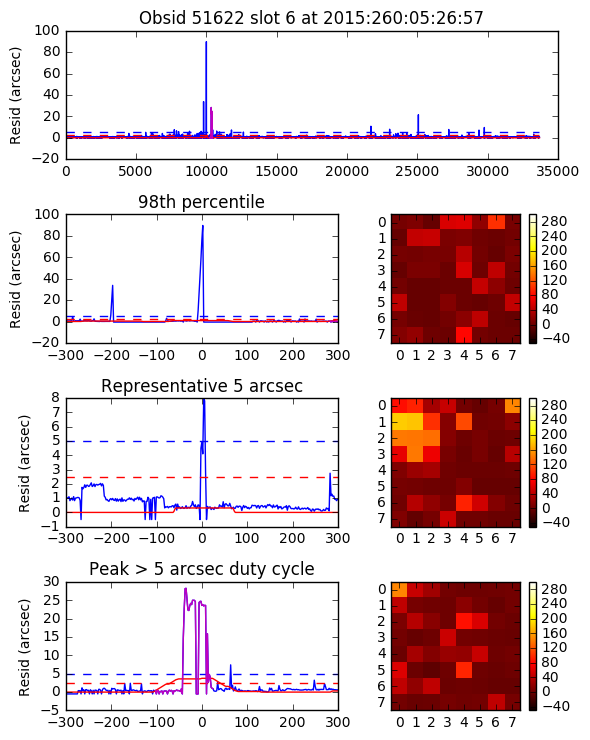

In [27]:
dat = get_dat(51622)
plot_dashboard(dat, slot=6)

### 18446 slot 5: just before 2016:234 BSH

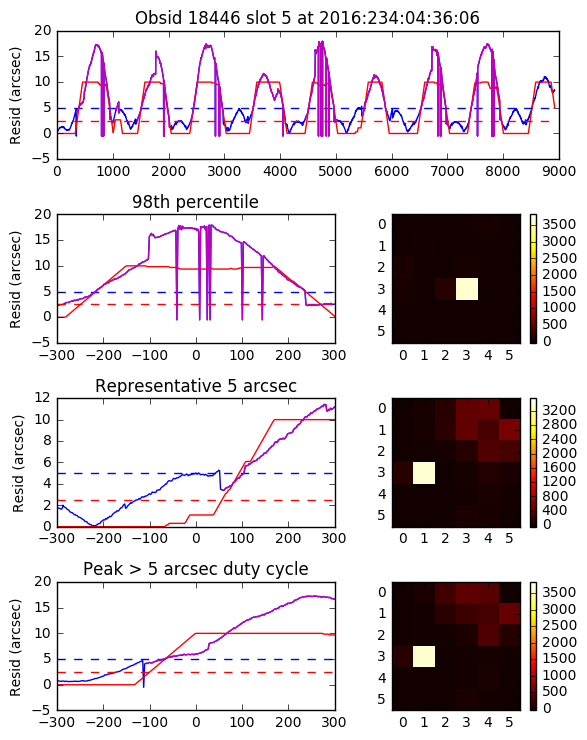

In [28]:
dat = get_dat(18446)
plot_dashboard(dat, slot=5)